In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Sampler
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as albu
import os, glob, sys, shutil
import cv2, itertools, random, pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
import sklearn
import math
import copy

In [3]:
import data_process
import utils
IMAGE_FOLDER = "/data/tcga/512dense/"

In [4]:
# random.seed(123)
# torch.manual_seed(123)
# torch.cuda.manual_seed_all(123)

# data

In [5]:
import pickle
with open("./data/APC_TP53_KRAS_PIK3CA_FAT4.pkl" , "rb") as fp:
    cohort_gene_dict = pickle.load(fp)
track_name = cohort_gene_dict['track_name']
del cohort_gene_dict['track_name']

In [6]:
# track_name_idx = [0, 1, 2]
track_name_idx = track_name.index('TP53')
patient_ids = list(cohort_gene_dict.keys())
patient_cls = list(cohort_gene_dict.values())
patient_cls = np.array(patient_cls)
# 先做 APC
patient_cls = patient_cls[:, track_name_idx]
lookup = dict(zip(patient_ids, patient_cls))
print(Counter(patient_cls))

del cohort_gene_dict

Counter({0: 226, 1: 211})


In [7]:
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skf.split(patient_ids, patient_cls):
    train_patient = [patient_ids[i] for i in train_index]
    valid_patient = [patient_ids[i] for i in test_index]
    train_cls = [lookup[i] for i in train_patient]
    valid_cls = [lookup[i] for i in valid_patient]
    print("# train patient:{}\n# valid patient:{}".format(Counter(train_cls), Counter(valid_cls)))
    del train_cls, valid_cls
    break

# train patient:Counter({0: 150, 1: 141})
# valid patient:Counter({0: 76, 1: 70})


In [8]:
train_images, valid_images, train_lookup, valid_lookup, train_npys = utils.data.load_data(train_patient=train_patient, valid_patient=valid_patient, \
                                                        patient_label_dict = lookup)

# train images:1016542
# valid images:445538
# train images:Counter({1: 540708, 0: 475834})
# valid images:Counter({1: 228670, 0: 216868})
# train npys:(0: 224, 1: 255)
# valid npys:(0: 109, 1: 122)


# dataloader

In [9]:
def to_tensor(x, **kwargs):
    x = x/255.
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing():
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    test_transform = [
        albu.RandomCrop(224, 224),
        albu.Flip(),
        albu.RandomRotate90(),
        albu.OneOf(
            [
                albu.ElasticTransform(p=1),
                albu.GridDistortion(p=1),
                albu.OpticalDistortion(p=1)
            ],
            p=0.9,
        ),
        albu.ShiftScaleRotate(border_mode=0, value=0),
        albu.IAAAdditiveGaussianNoise(),
        albu.GaussianBlur(),
        albu.OneOf(
            [
#                 albu.RandomBrightnessContrast(p=1),
#                 albu.HueSaturationValue(p=1),
                albu.HueSaturationValue(hue_shift_limit=60, sat_shift_limit=90, val_shift_limit=60, p=1),
                albu.ColorJitter(p=1),
            ], 
            p=0.9,
        ),
        
    ]
    return albu.Compose(test_transform)

def get_validation_augmentation():
    test_transform = [
#         albu.Resize(224, 224),
    ]
    return albu.Compose(test_transform)

In [10]:
class EvalDataset(Dataset): 
    def __init__(self, root_dir = IMAGE_FOLDER, images = None, augmentation = None, preprocessing = None):
        self.root = root_dir
        self.images = images
        self.augmentation = augmentation
        self.preprocessing = preprocessing
                    
    def __getitem__(self, index):
        img_name = self.images[index]
        svs_name = img_name.split("_")[0]
        patient_name = svs_name[:12]
        target = lookup[patient_name]
        
        full_path = os.path.join(self.root, svs_name, img_name+".jpg")
        image = data_process.wsi_utils.vips_get_image(full_path)
        
        if self.augmentation:
            img = self.augmentation(image = image)['image']
        if self.preprocessing:
            img = self.preprocessing(image = img)['image']
        return img, target, img_name
    
    def __len__(self):
        return len(self.images)

In [11]:
class CustomDataset(Dataset): 
    def __init__(self, root_dir, mode, images = None, lookup_table = None, 
                 augmentation = None, preprocessing = None, probability=[]): 
        self.root = root_dir
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        self.mode = mode
        self.labels = lookup_table
        self.images = images
        self.probability = probability
                    
    def __getitem__(self, index):
        if self.mode=='labeled':
            img_name = self.images[index]
            svs_name = img_name.split("_")[0]
            target = self.labels[img_name] 
            prob = self.probability[index]
            
            full_path = os.path.join(self.root, svs_name, img_name+".jpg")
            image = data_process.wsi_utils.vips_get_image(full_path)
            
            img1 = self.augmentation(image = image)['image']
            img2 = self.augmentation(image = image)['image']
            img1 = self.preprocessing(image = img1)['image']
            img2 = self.preprocessing(image = img2)['image']
            return img1, img2, target, prob, img_name  
        
        elif self.mode=='unlabeled':
            img_name = self.images[index]
            svs_name = img_name.split("_")[0]
            
            full_path = os.path.join(self.root, svs_name, img_name+".jpg")
            image = data_process.wsi_utils.vips_get_image(full_path)
            
            img1 = self.augmentation(image = image)['image']
            img2 = self.augmentation(image = image)['image']
            img1 = self.preprocessing(image = img1)['image']
            img2 = self.preprocessing(image = img2)['image']
            return img1, img2, img_name
        
        elif self.mode=='warmup':
            img_name = self.images[index]
            svs_name = img_name.split("_")[0]
            target = self.labels[img_name]
            
            full_path = os.path.join(self.root, svs_name, img_name+".jpg")
            image = data_process.wsi_utils.vips_get_image(full_path)  
            
            img1 = self.augmentation(image = image)['image']
            img2 = self.augmentation(image = image)['image']
            img1 = self.preprocessing(image = img1)['image']
            img2 = self.preprocessing(image = img2)['image']
            return img1, img2, target, img_name
    
    def __len__(self):
        return len(self.images)

In [12]:
class WrapperLoader():  
    def __init__(self, batch_size=32, num_workers=16, root_dir=IMAGE_FOLDER):

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.root_dir = root_dir

    def run(self, mode, labeled_images=[], unlabeled_images=[], clean_probability=None, filtered_lookup=None):
        if mode=='warmup':
            class_index = [[],[]]
            for index, name in enumerate(train_images):
                class_index[train_lookup[name]].append(index)
            if len(class_index[1]) > len(class_index[0]):
                primary_idnex, secondary_index = class_index[1], class_index[0]
            else:
                primary_idnex, secondary_index = class_index[0], class_index[1]
            # undersampling
            primary_idnex = random.sample(primary_idnex, len(secondary_index))
            data_sampler = utils.sampler.TwoStreamBatchSampler(primary_idnex, secondary_index, hyperParam["bs"],hyperParam["bs"]//2, is_random=True)
            
            warmup_dataset = CustomDataset(root_dir=self.root_dir, mode="warmup", 
                                        images=train_images, lookup_table=train_lookup,
                                        augmentation=get_training_augmentation(), preprocessing=get_preprocessing()) 
            trainloader = DataLoader(
                dataset=warmup_dataset, 
                batch_sampler=data_sampler,
                num_workers=self.num_workers,
                pin_memory=True)
            
            return trainloader
                                     
        elif mode=='train':
            labeled_prob = [clean_probability[i] for i in labeled_images]
            class_index = [[],[]]
            for index, name in enumerate(labeled_images):
                class_index[filtered_lookup[name]].append(index)
            data_sampler = utils.sampler.TwoStreamBatchSampler(class_index[1], class_index[0], hyperParam["bs"],hyperParam["bs"]//2, is_random=True)
            labeled_dataset = CustomDataset(root_dir=self.root_dir, mode="labeled",
                                            images=labeled_images, lookup_table=filtered_lookup, probability=labeled_prob,
                                            augmentation=get_training_augmentation(), preprocessing=get_preprocessing())            
            labeled_trainloader = DataLoader(
                dataset=labeled_dataset, 
                batch_sampler=data_sampler,
                num_workers=self.num_workers,
                pin_memory=True)        
            
            unlabeled_dataset =  CustomDataset(root_dir=self.root_dir, mode="unlabeled",
                                               images=unlabeled_images, lookup_table=filtered_lookup,
                                               augmentation=get_training_augmentation(), preprocessing=get_preprocessing())                   
            unlabeled_trainloader = DataLoader(
                dataset=unlabeled_dataset, 
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=self.num_workers,
                pin_memory=True)
            
            return labeled_trainloader, unlabeled_trainloader
        
        elif mode=="test":
            test_dataset = EvalDataset(root_dir=self.root_dir, images=valid_images, 
                                       augmentation=get_training_augmentation(), preprocessing=get_preprocessing()) 
            test_loader = DataLoader(
                test_dataset, 
                batch_size=self.batch_size*2, 
                shuffle=False, 
                num_workers=self.num_workers, 
                pin_memory=True)
            return test_loader

In [13]:
# all_dataset = CustomDataset(root_dir=IMAGE_FOLDER, mode="warmup", 
#             images=train_images, lookup_table=train_lookup,
#             augmentation=get_training_augmentation(), preprocessing=get_preprocessing())  
# plt.figure(figsize=(20,10))
# for i in range(5):
#     import random
#     rand = random.randint(0, len(all_dataset))
#     s_img, t_img, cls, patch_name = all_dataset[rand]
#     plt.subplot(2, 5, i+1)
#     plt.title(cls)
#     plt.imshow(s_img.transpose(1, 2, 0))
    
#     plt.subplot(2, 5, i+6)
#     plt.title(cls)
#     plt.imshow(t_img.transpose(1, 2, 0))

# MT

In [14]:
def update_ema_variables(model, ema_model, alpha, global_step):
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)

def sigmoid_rampup(current, rampup_length):
    """Exponential rampup from https://arxiv.org/abs/1610.02242"""
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))
    
def _format_logs(logs):
    str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
    s = ', '.join(str_logs)
    return s

In [15]:
def warmup(epoch, model, ema_model, optimizer, trainloader):
    global GLOBAL_STEP
    model.train()
    ema_model.train()
    
    logs = {}
    cls_loss_meter = utils.meter.AverageValueMeter()
    ema_cls_loss_meter = utils.meter.AverageValueMeter()
    consistency_loss_meter = utils.meter.AverageValueMeter()
    kl_loss_meter = utils.meter.AverageValueMeter()
    rank_regular_meter = utils.meter.AverageValueMeter()
    total_loss_meter = utils.meter.AverageValueMeter()
    
    metrics_meters = {}
    for metric in metrics:
        metrics_meters["Student_"+metric.__name__] = utils.meter.AverageValueMeter()
        metrics_meters["Teacher_"+metric.__name__] = utils.meter.AverageValueMeter()
    
    with tqdm(trainloader, desc="train", file=sys.stdout) as iterator:
        for i, (x, ema_x, y, image_names) in enumerate(iterator):
            x, ema_x, y = x.to(DEVICE), ema_x.to(DEVICE), y.to(DEVICE) # b*3*w*h, b*3*w*h, b*1, 

            pred, mu_logvar = model(x)
            ema_pred, ema_mu_logvar = ema_model(ema_x)
            ema_pred = torch.autograd.Variable(ema_pred.detach().data, requires_grad = False)
            
            """ cls loss"""
            cls_loss = cls_criterion(pred, y)
            ema_cls_loss = cls_criterion(ema_pred, y)
            
            """ LDDG """
            kl_loss = kl_criterion(mu_logvar[:, 0], mu_logvar[:, 1])
            feature = mu_logvar[:, 2]
            feature = feature[torch.randperm(len(feature))]
            
            rank_regular_value = rank_regular(feature)
            
            """ Consistency ramp-up from https://arxiv.org/abs/1610.02242 """
            consistency_weight = 100. * sigmoid_rampup(epoch, hyperParam["warm_up"])
            consistency_loss = consistency_criterion(pred, ema_pred)
            
            """ total loss"""
            loss = cls_loss + consistency_weight*consistency_loss + 0.01*kl_loss + 0.001*rank_regular_value
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            """ update ema model """
            ema_update_weight = 0.9 if (GLOBAL_STEP <= 10) else 0.99
            update_ema_variables(model, ema_model, ema_update_weight, GLOBAL_STEP)
            GLOBAL_STEP += 1

            # update loss logs
            cls_loss_meter.add(cls_loss.item())
            ema_cls_loss_meter.add(ema_cls_loss.item())
            consistency_loss_meter.add(consistency_loss.item())
            kl_loss_meter.add(kl_loss.item())
            rank_regular_meter.add(rank_regular_value.item())
            total_loss_meter.add(loss.item())
            
            loss_logs = {"total loss": total_loss_meter.mean, \
                         "Student_" + cls_criterion.__name__: cls_loss_meter.mean, \
                         "Teacher_" + cls_criterion.__name__: ema_cls_loss_meter.mean, \
                         consistency_criterion.__name__: consistency_loss_meter.mean, \
                         kl_criterion.__name__: kl_loss_meter.mean, \
                         "rank regular": rank_regular_meter.mean,
                        }
            logs.update(loss_logs)

            # update metrics logs
            for metric_fn in metrics:
                metric_value = metric_fn(pred, y).cpu().detach().numpy()
                metrics_meters["Student_"+metric_fn.__name__].add(metric_value)
                metric_value = metric_fn(ema_pred, y).cpu().detach().numpy()
                metrics_meters["Teacher_"+metric_fn.__name__].add(metric_value)
            metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
            logs.update(metrics_logs)

            s = _format_logs(logs)
            iterator.set_postfix_str(s)
            
    writer.add_scalar("{}/{}".format("Total Loss", "train"), total_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format(cls_criterion.__name__, "train"), cls_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format(cls_criterion.__name__, "train_ema"), ema_cls_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format(consistency_criterion.__name__, "train"), consistency_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format(kl_criterion.__name__, "train"), kl_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format("rank regular", "train"), rank_regular_meter.mean, epoch)
    writer.add_scalar("{}/{}".format(metrics[0].__name__, "train"), metrics_meters["Student_"+metrics[0].__name__].mean, epoch)
    writer.add_scalar("{}/{}".format(metrics[0].__name__, "train_ema"), metrics_meters["Teacher_"+metrics[0].__name__].mean, epoch)
    
    return logs

In [16]:
# Training
def train(epoch,model,ema_model,optimizer,labeled_trainloader,unlabeled_trainloader):
    global GLOBAL_STEP
    model.train()
    ema_model.train() # mean-teacher source code setting train() 

    logs = {}
    cls_loss_meter = utils.meter.AverageValueMeter()
    ema_cls_loss_meter = utils.meter.AverageValueMeter()
    consistency_loss_meter = utils.meter.AverageValueMeter()
    kl_loss_meter = utils.meter.AverageValueMeter()
    rank_regular_meter = utils.meter.AverageValueMeter()
    total_loss_meter = utils.meter.AverageValueMeter()
    
    with tqdm(labeled_trainloader, desc="train", file=sys.stdout) as iterator:
        for batch_idx, (inputs_x, inputs_x2, labels_x, w_x, image_names) in enumerate(iterator):      
            try:
                inputs_u, inputs_u2, unlabeled_image_names = unlabeled_train_iter.next() # b*3*h*w, b*3*h*w
            except:
                unlabeled_train_iter = iter(unlabeled_trainloader)
                inputs_u, inputs_u2, unlabeled_image_names = unlabeled_train_iter.next()                 
            batch_size = inputs_x.size(0)
            
            inputs_x, inputs_x2, labels_x, w_x = inputs_x.to(DEVICE), inputs_x2.to(DEVICE), labels_x.to(DEVICE), w_x.to(DEVICE)
            inputs_u, inputs_u2 = inputs_u.to(DEVICE), inputs_u2.to(DEVICE)
            
            model_inputs = torch.cat([inputs_x, inputs_u], dim=0) # 2b*3*h*w
            ema_model_inputs =  torch.cat([inputs_x2, inputs_u2], dim=0) # 2b*3*h*w
                        
            pred, mu_logvar = model(model_inputs)
            ema_pred, ema_mu_logvar = ema_model(ema_model_inputs)
            ema_pred = torch.autograd.Variable(ema_pred.detach().data, requires_grad = False)
            
            """ only labeled-data calculate CE loss """
            cls_loss = cls_criterion(pred[:batch_size], labels_x[:batch_size])
            ema_cls_loss = cls_criterion(ema_pred[:batch_size], labels_x[:batch_size])
            
            """ LDDG """
            kl_loss = kl_criterion(mu_logvar[:, 0], mu_logvar[:, 1])
            feature = mu_logvar[:, 2]
            feature = feature[torch.randperm(len(feature))]
            rank_regular_value = rank_regular(feature)
            
            """Consistency ramp-up from https://arxiv.org/abs/1610.02242""" 
            consistency_weight = 100. * sigmoid_rampup(epoch, hyperParam["warm_up"])
            consistency_loss = consistency_criterion(pred, ema_pred)
            
            """ total loss"""
            loss = cls_loss + consistency_weight*consistency_loss + 0.01*kl_loss + 0.001*rank_regular_value

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            """ update ema model """
            ema_update_weight = 0.9 if (GLOBAL_STEP <= 10) else 0.99
            update_ema_variables(model, ema_model, ema_update_weight, GLOBAL_STEP)
            GLOBAL_STEP += 1
            
            # update loss logs
            cls_loss_meter.add(cls_loss.item())
            ema_cls_loss_meter.add(ema_cls_loss.item())
            consistency_loss_meter.add(consistency_loss.item())
            kl_loss_meter.add(kl_loss.item())
            rank_regular_meter.add(rank_regular_value.item())
            total_loss_meter.add(loss.item())
            
            loss_logs = {"total loss": total_loss_meter.mean, \
                         "Student_" + cls_criterion.__name__: cls_loss_meter.mean, \
                         "Teacher_" + cls_criterion.__name__: ema_cls_loss_meter.mean, \
                         consistency_criterion.__name__: consistency_loss_meter.mean, \
                         kl_criterion.__name__: kl_loss_meter.mean, \
                         "rank regular": rank_regular_meter.mean,
                        }
            logs.update(loss_logs)
            
            s = _format_logs(logs)
            iterator.set_postfix_str(s)
            
    writer.add_scalar("{}/{}".format("Total Loss", "train"), total_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format(cls_criterion.__name__, "train"), cls_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format(cls_criterion.__name__, "train_ema"), ema_cls_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format(consistency_criterion.__name__, "train"), consistency_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format(kl_criterion.__name__, "train"), kl_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format("rank regular", "train"), rank_regular_meter.mean, epoch)
    writer.add_scalar("{}/{}".format(metrics[0].__name__, "train"), metrics_meters["Student_"+metrics[0].__name__].mean, epoch)
    writer.add_scalar("{}/{}".format(metrics[0].__name__, "train_ema"), metrics_meters["Teacher_"+metrics[0].__name__].mean, epoch)
    
    return logs

In [17]:
def validate(epoch, ema_model, valid_loader):
    ema_model.eval()
    logs = {}
    ema_cls_loss_meter = utils.meter.AverageValueMeter()
    metrics_meters = {metric.__name__: utils.meter.AverageValueMeter() for metric in metrics}
    
    patient_preds = {}
    with tqdm(valid_loader, desc="validate", file=sys.stdout) as iterator:
        for i, (ema_x, y, image_names) in enumerate(iterator):
            ema_x, y = ema_x.to(DEVICE), y.to(DEVICE)

            with torch.no_grad():
                ema_pred = ema_model(ema_x)
                ema_cls_loss = cls_criterion(ema_pred, y)

            # update loss logs
            ema_cls_loss_meter.add(ema_cls_loss.item())
            loss_logs = {cls_criterion.__name__: ema_cls_loss_meter.mean}
            logs.update(loss_logs)

            # update metrics logs
            for metric_fn in metrics:
                metric_value = metric_fn(ema_pred, y).cpu().detach().numpy()
                metrics_meters[metric_fn.__name__].add(metric_value)
            metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
            logs.update(metrics_logs)
            
            _, outputs = torch.max(ema_pred, 1)  
            outputs = outputs.detach().cpu().numpy()
            for pid, p in zip(image_names, outputs):
                pid = pid[:12]
                if pid not in patient_preds:
                    patient_preds[pid] = [0,0]
                patient_preds[pid][p] += 1
            
            s = _format_logs(logs)
            iterator.set_postfix_str(s)
    
    y_pred, y_gt = [], []
    for key, values in patient_preds.items():
        y_gt.append(lookup[key])
        y_pred.append(values[1]/(values[0]+values[1]))
    auc = sklearn.metrics.roc_auc_score(y_gt, y_pred)
    precision, recall, _thresholds = sklearn.metrics.precision_recall_curve(y_gt, y_pred)
    aupr = sklearn.metrics.auc(recall, precision)
    print("\n| Test Epoch #%d\t AUC: %.2f AUPR: %2f\n" %(epoch,auc,aupr))  
    
    logs.update({"AUC": auc})
    logs.update({"AUPR": aupr})
    
    writer.add_scalar("{}/{}".format(cls_criterion.__name__, "valid_ema"), ema_cls_loss_meter.mean, epoch)
    writer.add_scalar("{}/{}".format("Patient AUC", "valid"), auc, epoch)
    writer.add_scalar("{}/{}".format("Patient AUPR", "valid"), aupr, epoch)
    writer.add_scalar("{}/{}".format(metrics[0].__name__, "valid"), metrics_meters[metrics[0].__name__].mean, epoch)
    
    return logs

In [18]:
def eval_train(epoch, ema_model):
    global filtered_lookup
    global ensemble_prediction
    
    ema_model.eval()
    with tqdm(train_npys, desc="eval train", file=sys.stdout) as iterator:
        for idx, npy in enumerate(iterator):
            x_y_pairs = np.load(npy)
            svs_name = npy.split("/")[-1][:-4]
            # only GT=1, filter noise
            if lookup[svs_name[:12]] == 1:
                eval_images = ["{}_{}_{}".format(svs_name, x, y) for x, y in x_y_pairs]

                eval_dataset = EvalDataset(
                                images=eval_images,
                                augmentation=get_validation_augmentation(),
                                preprocessing=get_preprocessing())
                eval_loader = DataLoader(eval_dataset, batch_size=hyperParam["bs"]*4, shuffle=False, num_workers=16, pin_memory=True)
                losses = np.array([])
                patch_names = []
                for batch_idx, (x, y, image_names) in enumerate(eval_loader):
                    x, y = x.cuda(), y.cuda()
                    with torch.no_grad():
                        pred = ema_model(x) 
                        loss = filter_CE(pred, y)  # reduction = "none"
                    assert loss.size()[0] == x.size()[0], "reduction should be none"
                    loss = loss.detach().cpu().numpy()
                    image_names = list(image_names)
                    pred = pred.detach().cpu().numpy()
                    for pid, p in zip(image_names, pred): # prediction ensemble
                        ensemble_prediction[pid] = 0.1*ensemble_prediction[pid]+0.9*p
                    losses = np.concatenate((losses, loss))
                    patch_names.extend(image_names)    
                    
                GMM_filter_noisy(patch_names, losses)
    
    print("filtered: {}".format(Counter(list(filtered_lookup.values()))))
    
    labeled_images = []
    unlabeled_images = []
    for key, value in filtered_lookup.items():
        if value == -1:
            unlabeled_images.append(key)
        else:
            labeled_images.append(key)
    
    return labeled_images, unlabeled_images

def SELF_filter_noisy(patch_names):
    global filtered_lookup
    global ensemble_prediction
    global train_lookup
    for pid in patch_names:
        agreement = np.argmax(ensemble_prediction[pid])
        if agreement != train_lookup[pid]:
            filtered_lookup[pid] = -1
    return

def GMM_filter_noisy(patch_names=None, patch_losses=None):
    global filtered_lookup
    global ensemble_prediction
    """ normalize loss"""
    patch_losses = (patch_losses - patch_losses.min())/(patch_losses.max() - patch_losses.min() + 1e-10)
    """ fit a two-component GMM to the loss """
    gmm = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
    input_losses = patch_losses.reshape(-1,1)
    
    gmm.fit(input_losses)
    gmm_prob = gmm.predict_proba(input_losses) 
    gmm_prob = gmm_prob[:,gmm.means_.argmin()]
    gmm_pred = (gmm_prob > hyperParam["p_threshold"])     

    labeled_index = gmm_pred.nonzero()[0]
    unlabeled_index = (1-gmm_pred).nonzero()[0]
    """ set unlabeled """
    for index in unlabeled_index:
        filtered_lookup[patch_names[index]] = -1
    for pid, p in zip(patch_names, gmm_prob):
        clean_probability[pid] = p
    return 

# loss

In [19]:
class SoftmaxMeanSquareLoss(nn.Module):
    def __init__(self):
        super().__init__()
    @property
    def __name__(self):
        return "SoftmaxMeanSquareLoss"
    def forward(self, y_pred, y_gt):
        y_pred = F.softmax(y_pred, dim = 1)
        y_gt = F.softmax(y_gt, dim = 1)
        return nn.MSELoss()(y_pred, y_gt) 
    
class KLLoss(nn.Module):
    def __init__(self):
        super().__init__()
    @property
    def __name__(self):
        return "KLGuassianLoss"
    def forward(self, mu, logvar):
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return kl_loss 


class LowRank(nn.Module):
    def __init__(self, num_class = 2):
        super().__init__()
        self.num_class = num_class
    @property
    def __name__(self):
        return "low rank"
    def forward(self, x):
        try:
            U, S, V = torch.svd(x)
        except: # torch.svd may have convergence issues for GPU and CPU.
            U, S, V = torch.svd(x + 1e-4*x.mean()*torch.rand(l, h))
            
        return S[self.num_class] 

In [20]:
from encoders.resnet import resnet18, Flatten
from encoders.shufflenetv2 import shufflenet_v2_x1_0
class VANet(nn.Module):
    def __init__(self, num_class = 2, feature_dim = 80, input_size = 512):
        super(VANet, self).__init__()
        self.num_class = num_class
        self.feature_dim = feature_dim
        self.feature_size = input_size//32
        #self.encoder = resnet18()
        self.encoder = shufflenet_v2_x1_0()
        """remove avgpool, flatten, fc """
        self.encoder = torch.nn.Sequential(*(list(self.encoder.children())[:-3])) # resnet b*512*7*7
        
        self.mu = nn.Sequential(
            nn.Conv2d(1024, 256, (self.feature_size, self.feature_size), stride=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(256, self.feature_dim),
        )
        self.logvar = nn.Sequential(
            nn.Conv2d(1024, 256, (self.feature_size, self.feature_size), stride=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(256, self.feature_dim),
        )
        self.cls = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Flatten(),
            nn.Linear(1024, self.num_class)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        if self.training:
            mu = self.mu(x)
            logvar = self.logvar(x)
            feature = self.reparameterization(mu, logvar)
            x = self.cls(x)
            return x, torch.stack([mu, logvar, feature], dim=1)
        else:
            x = self.cls(x)
            return x
    
    def reparameterization(self, mu, logvar):
        std = torch.exp(logvar / 2)
        sampled_z = torch.normal(mu, std)
        z = sampled_z * std + mu
        return z

In [21]:
def create_model():
    from utils.weight_init import weight_init
    model = VANet(num_class=2, input_size=224)
    model.apply(weight_init)
    model = model.cuda()
    return model

# training

In [22]:
hyperParam = {
    "num_class": 2,
#     "T": 0.5,
#     "alpha": 4,
#     "lambda_u": 20,
#     "p_threshold": 0.5, # clean label threshold tao
#     "ensemble_momentum": 0.9,
    "num_epochs": 30,
    "lr_cosine":15,
    "warm_up": 0,
    "bs": 32
}
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

GLOBAL_STEP = 0 

loader = WrapperLoader(batch_size=hyperParam["bs"], num_workers=16)
valid_loader = loader.run('test')

In [23]:
# """ for noisy label"""
# ensemble_prediction = {key: 0 for key, value in train_lookup.items()} # initialize ensemble predictions of all samples
# clean_probability = {key: 1 for key, value in train_lookup.items()}
# """ for filter noisy label """
# filtered_lookup = copy.deepcopy(train_lookup) 

In [24]:
from datetime import datetime
from pytz import timezone    
taipei = timezone('Asia/Taipei')
taipei_time = datetime.now(taipei)
current_time = taipei_time.strftime('%Y-%m-%d-%H')

model_name = current_time + "_AUPRLoss_TP53_MT_shufflenetv2_LDDG"
log_folder_name = os.path.join('/data/log_folder/demo/demo/',model_name)
writer = SummaryWriter(log_dir=log_folder_name, flush_secs=3)
print(log_folder_name)

/data/log_folder/demo/demo/2021-02-03-10_AUPRLoss_TP53_MT_shufflenetv2_LDDG


In [25]:
print('| Building net')
model = create_model()
ema_model = create_model()
cudnn.benchmark = True

| Building net


In [26]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
warm_up_with_cosine_lr = lambda epoch: (epoch+1) / hyperParam["warm_up"] if epoch < hyperParam["warm_up"] \
    else 0.5 * ( math.cos((epoch - hyperParam["warm_up"]) /(hyperParam["lr_cosine"] - hyperParam["warm_up"]) * math.pi) + 1)
scheduler = torch.optim.lr_scheduler.LambdaLR( optimizer, lr_lambda=warm_up_with_cosine_lr)

# warm_up_with_step_lr
# gamma = 0.1; stepsize = 1
# warm_up_with_step_lr = lambda epoch: (epoch+1) / hyperParam["warm_up"] if epoch < hyperParam["warm_up"] \
#     else gamma**( ((epoch - hyperParam["warm_up"]) /(15 - hyperParam["warm_up"]))//stepsize*stepsize)


# cls_criterion = utils.losses.CrossEntropy().cuda()
cls_criterion = utils.global_objective.AUCPRHingeLoss(num_classes=2).cuda()

consistency_criterion = SoftmaxMeanSquareLoss().cuda()
kl_criterion = KLLoss().cuda()
rank_regular = LowRank().cuda()

filter_CE = utils.losses.CrossEntropy(reduction='none').cuda()
metrics = [utils.metrics.Fscore()]

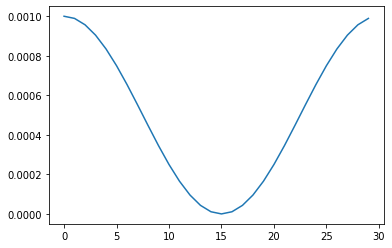

In [27]:
# test
a_ = []
for i in range(30):
    lr = warm_up_with_cosine_lr(i)*1e-3
    a_.append(lr)
plt.plot(a_)

In [28]:
from torch.optim.swa_utils import AveragedModel, SWALR
swa_model = AveragedModel(ema_model)
swa_scheduler = SWALR(optimizer, swa_lr=0.005)
swa_start = 15

In [ ]:
max_value = 0.5
for epoch in range(0, 30):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print("Epoch [{}/{}], LR {:.6f}".format(epoch, hyperParam["num_epochs"], lr))
    writer.add_scalar("{}".format("Learning Rate"), lr, epoch)
    
#     if epoch < hyperParam["warm_up"]:    
#         warmup_trainloader = loader.run('warmup')
#         print('Warmup')
#         warmup(epoch, model, ema_model, optimizer, warmup_trainloader)    
#     else:         
#         labeled_images, unlabeled_images = eval_train(epoch, ema_model) 
#         print('Train')
#         labeled_trainloader, unlabeled_trainloader = loader.run('train', 
#                                             labeled_images=labeled_images, unlabeled_images=unlabeled_images,
#                                             clean_probability=clean_probability, filtered_lookup=filtered_lookup)
#         train(epoch, model, ema_model, optimizer,labeled_trainloader, unlabeled_trainloader)
    
    print('Warmup')
    warmup_trainloader = loader.run('warmup')
    warmup(epoch, model, ema_model, optimizer, warmup_trainloader)  
    
    if epoch > swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step()
    
    print('Valid')
    logs = validate(epoch,ema_model,valid_loader)
    
    if max_value < logs["AUC"]:
        max_value = logs["AUC"]
    save_path = "/data/weight/gene/tp53/{}_EMA_epoch_{}_AUROC_{:.4f}".format(model_name, epoch, logs["AUC"])
    torch.save(ema_model.state_dict(), save_path)
    save_path = "/data/weight/gene/tp53/{}_epoch_{}_AUROC_{:.4f}".format(model_name, epoch, logs["AUC"])
    torch.save(model.state_dict(), save_path)

Epoch [0/30], LR 0.001000
Warmup
train:   0%|          | 3/29739 [00:06<38:18:16,  4.64s/it, total loss - 8.289, Student_AUPRLoss - 1.912, Teacher_AUPRLoss - 1.947, SoftmaxMeanSquareLoss - 0.06164, KLGuassianLoss - 2.749, rank regular - 185.4, Student_fscore - 0.1739, Teacher_fscore - 6.25e-09]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:760.)
  """


train:  46%|████▌     | 13637/29739 [40:33<1:28:47,  3.02it/s, total loss - 0.5275, Student_AUPRLoss - 0.4927, Teacher_AUPRLoss - 0.5288, SoftmaxMeanSquareLoss - 0.0002456, KLGuassianLoss - 0.2141, rank regular - 8.131, Student_fscore - 9.003e-05, Teacher_fscore - 6.25e-09]

# swa

In [46]:
torch.optim.swa_utils.update_bn(valid_loader, swa_model, device=DEVICE)

In [47]:
validate(epoch,swa_model,valid_loader)

validate: 100%|██████████| 6962/6962 [21:37<00:00,  5.37it/s, CrossEntropyLoss - 0.6893, fscore - 0.4062]   

| Test Epoch #29	 AUC: 0.61 AUPR: 0.698114



{'CrossEntropyLoss': 0.6893467143738762,
 'fscore': 0.4062457853962077,
 'AUC': 0.6104116222760291,
 'AUPR': 0.6981144739359819}

In [50]:
save_path = "/data/weight/gene/tp53/{}_SWA_epoch_{}_AUROC_{:.4f}".format(model_name, epoch, 0.6104)
torch.save(swa_model.state_dict(), save_path)

# visual 

In [ ]:
ema_model.eval()
swa_model.eval()

In [ ]:
# using_npy = "/data/tcga/kmeans_cluster_32/"
using_npy = "/data/tcga/512denseTumor/"
valid_npy_pos = []
valid_npy_neg = []
for npy in sorted(glob.glob(os.path.join(using_npy, "*.npy"))):    
    patient = npy.split("/")[-1][:12]
    if patient in valid_patient:
        if lookup[patient] == 1:
            valid_npy_pos.append(npy)
        else:
            valid_npy_neg.append(npy)

In [ ]:
TT_positive_pred = {}
with tqdm(valid_npy_pos, desc="test", file=sys.stdout) as iterator:
    for npy in iterator:
        svs_name = npy.split("/")[-1][:-4]
        x_y_pairs = np.load(npy)
        image_names = ["{}_{}_{}".format(svs_name, x, y) for x, y in x_y_pairs]

        test_dataset = EvalDataset(
            images = image_names,
            augmentation = get_validation_augmentation(),
            preprocessing = get_preprocessing(),
        )
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=16, pin_memory=True)
        all_predictions = np.array([])
        svs_pred = [0,0]
        for images, labels, patch_name in test_loader:
            with torch.no_grad():
#                 predictions = ema_model.forward(images.cuda())
                predictions = swa_model.forward(images.cuda())
            
            predictions = torch.softmax(predictions, dim = 1)
            predictions = predictions[:, 1].detach().cpu().numpy()
            all_predictions = np.concatenate((all_predictions, predictions))
            for p in predictions:
                if p > 0.5:
                    svs_pred[1] += 1
                else:
                    svs_pred[0] += 1
        y_pred = svs_pred[1]/(svs_pred[0]+svs_pred[1])
        if svs_name[:12] not in TT_positive_pred:
            TT_positive_pred[svs_name[:12]] = []
        TT_positive_pred[svs_name[:12]].append(y_pred)
        
        title = "{}_gt={}_pred={:.4f}".format(svs_name, lookup[svs_name[:12]], y_pred)
        data_process.stitch.stitch(wsi_name = svs_name, x_y_pairs = x_y_pairs, preds = all_predictions, title=title)

In [ ]:
TT_negative_pred = {}
with tqdm(valid_npy_neg, desc="test", file=sys.stdout) as iterator:
    for npy in iterator:
        svs_name = npy.split("/")[-1][:-4]
        x_y_pairs = np.load(npy)
        image_names = ["{}_{}_{}".format(svs_name, x, y) for x, y in x_y_pairs]

        test_dataset = EvalDataset(
            images = image_names,
            augmentation = get_validation_augmentation(),
            preprocessing = get_preprocessing(),
        )
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=16, pin_memory=True)
        all_predictions = np.array([])
        svs_pred = [0,0]
        for images, labels, patch_name in test_loader:
            with torch.no_grad():
#                 predictions = ema_model.forward(images.cuda())
                predictions = swa_model.forward(images.cuda())
            predictions = torch.softmax(predictions, dim = 1)
            predictions = predictions[:, 1].detach().cpu().numpy()
            all_predictions = np.concatenate((all_predictions, predictions))
            for p in predictions:
                if p > 0.5:
                    svs_pred[1] += 1
                else:
                    svs_pred[0] += 1
        y_pred = svs_pred[1]/(svs_pred[0]+svs_pred[1])
        if svs_name[:12] not in TT_negative_pred:
            TT_negative_pred[svs_name[:12]] = []
        TT_negative_pred[svs_name[:12]].append(y_pred)
        
        title = "{}_gt={}_pred={:.4f}".format(svs_name, lookup[svs_name[:12]], y_pred)
        data_process.stitch.stitch(wsi_name = svs_name, x_y_pairs = x_y_pairs, preds = all_predictions, title=title)

In [ ]:
preds = [np.amax(values) for key, values in TT_positive_pred.items()] \
        + [np.amax(values) for key, values in TT_negative_pred.items()]
gt = [1]*len(TT_positive_pred) + [0]*len(TT_negative_pred)
print(roc_auc_score(gt, preds))